# Setup

In [1]:
import random
import itertools
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

import seaborn as sns
color = sns.color_palette()
import matplotlib.pyplot as plt 
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from nltk.corpus import stopwords
STOP_WORDS = set(stopwords.words('english'))
from nltk import word_tokenize, ngrams

from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import resample
from sklearn.metrics import log_loss
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn import svm
from time import time
from collections import defaultdict

import wisardpkg as wp

# Pre-processing

## Importing...

In [2]:
df = {
    "cooking": pd.read_csv('../dataset/processed/cooking.csv', usecols=['title', 'content']),
    "crypto": pd.read_csv('../dataset/processed/crypto.csv', usecols=['title', 'content']),
    "robotics": pd.read_csv('../dataset/processed/robotics.csv', usecols=['title', 'content']),
    "biology": pd.read_csv('../dataset/processed/biology.csv', usecols=['title', 'content']),
    "travel": pd.read_csv('../dataset/processed/travel.csv', usecols=['title', 'content']),
    "diy": pd.read_csv('../dataset/processed/diy.csv', usecols=['title', 'content']),
}

## Generating new .csv file with title+content and class columns...

In [3]:
with open('../dataset/processed/data.csv', 'w') as f:
    f.write('title_content|label\n')
    for _class in df:
        df[_class]['title_content'] = df[_class][['title', 'content']].apply(lambda x: '{} {}'.format(x[0],x[1]),
                                                                             axis=1)
        df[_class]['label'] = _class
        df[_class].to_csv(f, sep='|', columns=['title_content', 'label'], header=False, index=False)

# Data Analysis

## Exploration

In [4]:
dataset = pd.read_csv('../dataset/processed/data.csv', sep='|')
dataset.describe()

,title_content,label
count,87000,87000
unique,86988,6
top,what the white residue pots after cooking bean...,diy
freq,2,25918


## Labels distribution (percentage)

In [5]:
labels = dataset['label'].value_counts()
print(labels.sort_index()/labels.sum()*100)

biology     15.167816
cooking     17.705747
crypto      11.990805
diy         29.790805
robotics     3.185057
travel      22.159770
Name: label, dtype: float64


### Histogram

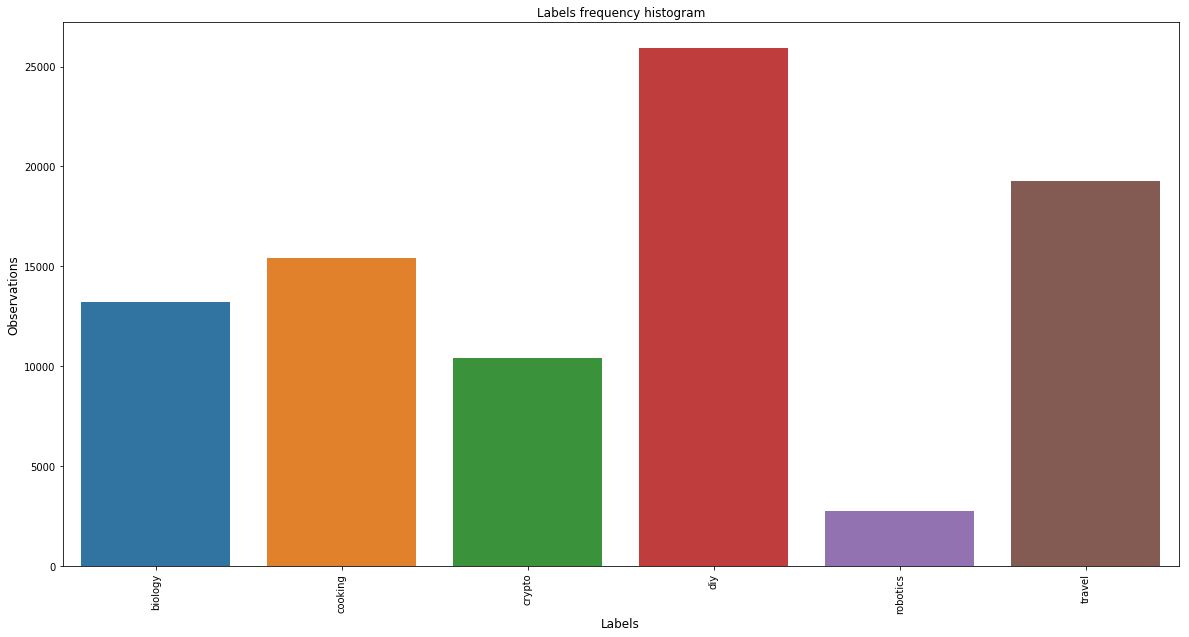

biology     13196
cooking     15404
crypto      10432
diy         25918
robotics     2771
travel      19279
Name: label, dtype: int64


In [6]:
fig = plt.figure(figsize=(20, 10))
ax1 = sns.countplot(dataset['label'].sort_values())
plt.ylabel('Observations', fontsize=12)
plt.xlabel('Labels', fontsize=12)
plt.xticks(rotation='vertical')
plt.title('Labels frequency histogram')
plt.show()
print(labels.sort_index())

## Word distribution

### Statistics of the number of words (size) of title_content text field

In [7]:
dataset['size'] = dataset['title_content'].apply(lambda x : len(str(x).split()))
sizes = dataset['size'].value_counts()
print('The top 20 most frequent size of title_content, and their respective frequency:')
print(sizes.nlargest(20))

The top 20 most frequent size of title_content, and their respective frequency:
44    1065
39    1058
35    1055
42    1053
51    1023
45    1023
47    1016
50    1008
41    1008
37     995
36     989
55     983
38     982
46     978
40     959
33     956
32     953
34     952
31     949
43     948
Name: size, dtype: int64


### Histogram

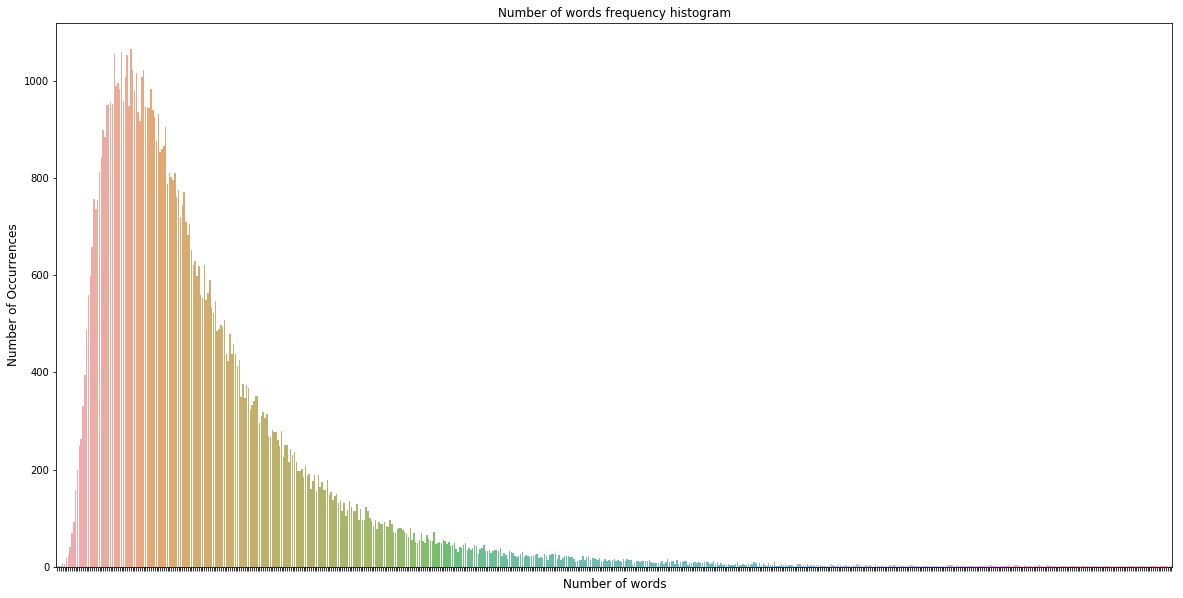

In [8]:
fig = plt.figure(figsize=(20, 10))
ax1 = sns.barplot(sizes.index, sizes.values, alpha=0.8)
ax1.set_xticklabels([])
plt.title('Number of words frequency histogram')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Number of words', fontsize=12)
plt.show()

## Data example

### Robotics texts with more than 200 words

In [9]:
filtered_data = dataset[(dataset.label == 'robotics') & (dataset.title_content.apply(lambda x : len(str(x).split())) > 200)]
filtered_data.describe()

,size
count,237.000000
mean,299.438819
std,133.648324
min,201.000000
25%,226.000000
50%,257.000000
75%,318.000000
max,1276.000000


### Cell content example

In [10]:
line=61041
print('TEXT: {0}'.format(dataset.loc[61041, 'title_content']))
print('LABEL: {0}'.format(dataset.loc[61041, 'label']))
print('LENGTH: {0} words.'.format(len(dataset.loc[61041, 'title_content'].split())))

TEXT: visa needed for transit heatrow wife ukrainian citizen with romanian residency permit have tickets for flight madrid heatrow seoul see below details jue iberia turista madrid adolfo rez barajas terminal londres heathrow terminal jue british airways turista londres heathrow terminal seoul incheon want understand she needs transit visa not far that there the datv visa which can used you will not thourgh border control but don know this the case not will not have checkin our luggage but there any other border control that might have pass the terminals will change and not both flights will depart from terminal according this you don need apply for one you have eea family permit which seems the case this situation she not required any visa all
LABEL: travel
LENGTH: 124 words.


In [11]:
ds = dataset

# Bag-of-Words

In [12]:
tfidf = TfidfVectorizer(analyzer='word',
                        stop_words=STOP_WORDS,
                        ngram_range=(1,1),
                        max_df=0.7, min_df=2,
                        sublinear_tf=True)
X = tfidf.fit_transform(ds['title_content'])
print(X.shape)

l_enc = LabelEncoder()
y = l_enc.fit_transform(ds['label'])
print('Encoded labels: ', list([(i, l_enc.classes_[i]) for i in range(0, len(l_enc.classes_))]))

(87000, 37087)
Encoded labels:  [(0, 'biology'), (1, 'cooking'), (2, 'crypto'), (3, 'diy'), (4, 'robotics'), (5, 'travel')]


# Dimensionality reduction

In [13]:
svd = TruncatedSVD(n_components=1000, algorithm='randomized')
X_svd = svd.fit_transform(X)
print('Shape of svd matrix: ', X_svd.shape)

Shape of svd matrix:  (87000, 1000)


# Split Train/Test examples

In [14]:
# X = np.concatenate([svd_titulo, svd_resumo], axis=1)
X_train, X_valid, y_train, y_valid = train_test_split(X_svd, y, test_size=0.2, random_state=283)

print('X_train matrix shape is: {0}'.format(X_train.shape))
print('X_valid matrix shape is: {0}'.format(X_valid.shape))
print('y_train matrix shape is: {0}'.format(y_train.shape))
print('y_valid matrix shape is: {0}'.format(y_valid.shape))

X_train matrix shape is: (69600, 1000)
X_valid matrix shape is: (17400, 1000)
y_train matrix shape is: (69600,)
y_valid matrix shape is: (17400,)


# Functions

In [15]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
      
    plt.figure(figsize=(12,6))
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        plt.title(title + " normalized confusion matrix")
    else:
        plt.title(title + ' confusion matrix, without normalization')
        
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    #print(cm)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    plt.show()
    

def benchmark(clf, X_train, y_train, X_test, y_test):

    print("Training: ", clf)
    t0 = time()
    clf.fit(X_train, y_train)
    train_time = time() - t0
    print("train time: %0.3fs" % train_time)

    t0 = time()
    pred = clf.predict(X_test)
    test_time = time() - t0
    print("test time:  %0.3fs" % test_time)

    score = accuracy_score(y_test, pred)
    print("accuracy:   %0.3f" % score)
    
    clf_descr = str(clf).split('(')[0]
    print("Done with " + clf_descr)
    print('-' * 80)
    
    return clf_descr, score, train_time, test_time


def one_hot(real_vec, min_value=-1.0, max_value=1.0, n=10):
    vec = []
    for v in real_vec:
        if v == max_value:
            rang = [0] * n
            rang[-1] = 1
            vec.extend(rang)
        else:
            rang = [0] * n
            t = (max_value - min_value)
            p = v - min_value
            s = int((p / t) * n)
            rang[s] = 1
            vec.extend(rang)
    return np.array(vec)


def show_retina(X, rows=50, columns=10): 
    pixels = np.array(X, dtype='uint8')
    # Reshape the array into 28 x 28 array (2-dimensional array)
    pixels = pixels.reshape((columns, rows))
    # Plot
    plt.imshow(pixels, cmap='gray', interpolation='nearest')
    plt.show()

# KFold

In [16]:
kf = StratifiedKFold(n_splits=10)

resultsGaussianNB = []
resultsBernoulliNB = []
resultsRandomForest = []
resultsSVM = []


for train, test in kf.split(X_train, y_train):
    resultsGaussianNB.append(benchmark(GaussianNB(), X_train[train], y_train[train], X_train[test], y_train[test]))
    resultsBernoulliNB.append(benchmark(BernoulliNB(), X_train[train], y_train[train], X_train[test], y_train[test]))
    resultsRandomForest.append(benchmark(RandomForestClassifier(n_jobs=16), X_train[train], y_train[train], X_train[test], y_train[test]))
    resultsSVM.append(benchmark(svm.LinearSVC(), X_train[train], y_train[train], X_train[test], y_train[test]))

Training:  GaussianNB(priors=None)
train time: 1.663s
test time:  0.528s
accuracy:   0.800
Done with GaussianNB
--------------------------------------------------------------------------------
Training:  BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)
train time: 2.147s
test time:  0.227s
accuracy:   0.902
Done with BernoulliNB
--------------------------------------------------------------------------------
Training:  RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=16,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
train time: 4.869s
test time:  0.123s
accuracy:   0.910
Done with RandomForestClassifier
--------------------------------------------

train time: 17.669s
test time:  0.026s
accuracy:   0.975
Done with LinearSVC
--------------------------------------------------------------------------------
Training:  GaussianNB(priors=None)
train time: 1.697s
test time:  0.562s
accuracy:   0.805
Done with GaussianNB
--------------------------------------------------------------------------------
Training:  BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)
train time: 2.176s
test time:  0.231s
accuracy:   0.902
Done with BernoulliNB
--------------------------------------------------------------------------------
Training:  RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=16,
            oob_score=False, random_state=None, verbose=0,
     

In [17]:
_sum_nbg, _sum_nbb, _sum_rf, _sum_svm = 0, 0, 0, 0

for i in range(len(resultsGaussianNB)):
    _sum_nbg += resultsGaussianNB[i][1]
    _sum_nbb += resultsBernoulliNB[i][1]
    _sum_rf += resultsRandomForest[i][1]
    _sum_svm += resultsSVM[i][1]
    
print('Mean Accuracy of the Gaussian Naïve-Bayes Classifier was {0:0.2f}%.'.format(_sum_nbg/len(resultsGaussianNB)))
print('Mean Accuracy of the Bernoulli Naïve-Bayes Classifier was {0:0.2f}%.'.format(_sum_nbb/len(resultsBernoulliNB)))
print('Mean Accuracy of the Random Forrest Classifier was {0:0.2f}%.'.format(_sum_rf/len(resultsRandomForest)))
print('Mean Accuracy of the SVM Classifier was {0:0.2f}%.'.format(_sum_svm/len(resultsSVM)))
print()

_sum_nbg2, _sum_nbb2, _sum_rf2, _sum_svm2 = 0, 0, 0, 0

for i in range(len(resultsGaussianNB)):
    _sum_nbg2 += resultsGaussianNB[i][2]
    _sum_nbb2 += resultsBernoulliNB[i][2]
    _sum_rf2 += resultsRandomForest[i][2]
    _sum_svm2 += resultsSVM[i][2]
    
print('Mean Train Time of the Gaussian Naïve-Bayes Classifier was {0:0.3f}s.'.format(_sum_nbg2/len(resultsGaussianNB)))
print('Mean Train Time of the Bernoulli Naïve-Bayes Classifier was {0:0.3f}s.'.format(_sum_nbb2/len(resultsBernoulliNB)))
print('Mean Train Time of the Random Forrest Classifier was {0:0.3f}s.'.format(_sum_rf2/len(resultsRandomForest)))
print('Mean Train Time of the SVM Classifier was {0:0.3f}s.'.format(_sum_svm2/len(resultsSVM)))
print()

_sum_nbg3, _sum_nbb3, _sum_rf3, _sum_svm3 = 0, 0, 0, 0

for i in range(len(resultsGaussianNB)):
    _sum_nbg3 += resultsGaussianNB[i][3]
    _sum_nbb3 += resultsBernoulliNB[i][3]
    _sum_rf3 += resultsRandomForest[i][3]
    _sum_svm3 += resultsSVM[i][3]
    
print('Mean Test Time of the Gaussian Naïve-Bayes Classifier was {0:0.3f}s.'.format(_sum_nbg3/len(resultsGaussianNB)))
print('Mean Test Time of the Bernoulli Naïve-Bayes Classifier was {0:0.3f}s.'.format(_sum_nbb3/len(resultsBernoulliNB)))
print('Mean Test Time of the Random Forrest Classifier was {0:0.3f}s.'.format(_sum_rf3/len(resultsRandomForest)))
print('Mean Test Time of the SVM Classifier was {0:0.3f}s.'.format(_sum_svm3/len(resultsSVM)))

Mean Accuracy of the Gaussian Naïve-Bayes Classifier was 0.81%.
Mean Accuracy of the Bernoulli Naïve-Bayes Classifier was 0.90%.
Mean Accuracy of the Random Forrest Classifier was 0.91%.
Mean Accuracy of the SVM Classifier was 0.97%.

Mean Train Time of the Gaussian Naïve-Bayes Classifier was 1.741s.
Mean Train Time of the Bernoulli Naïve-Bayes Classifier was 2.260s.
Mean Train Time of the Random Forrest Classifier was 4.894s.
Mean Train Time of the SVM Classifier was 17.190s.

Mean Test Time of the Gaussian Naïve-Bayes Classifier was 0.563s.
Mean Test Time of the Bernoulli Naïve-Bayes Classifier was 0.244s.
Mean Test Time of the Random Forrest Classifier was 0.124s.
Mean Test Time of the SVM Classifier was 0.026s.


## Naïve-Bayes Gaussian

Naïve-Bayes Gaussian train time: 1.920s
Naïve-Bayes Gaussian test time: 1.445s
Accuracy: 80.109%


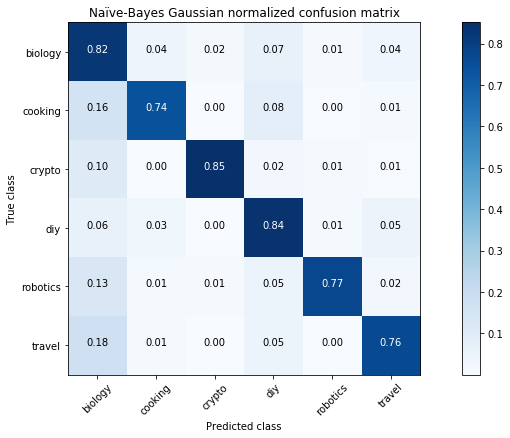

In [18]:
nbg = GaussianNB()

t0 = time()
nbg.fit(X_train, y_train)
print('Naïve-Bayes Gaussian train time: {0:0.3f}s'.format(time()-t0))

t0 = time()
y_pred = nbg.predict(X_valid) 
print('Naïve-Bayes Gaussian test time: {0:0.3f}s'.format(time()-t0))
                          
cm = confusion_matrix(y_valid, y_pred)                      
print('Accuracy: {0:0.3f}%'.format(100*accuracy_score(y_valid, y_pred)))  
plot_confusion_matrix(cm, l_enc.classes_, title='Naïve-Bayes Gaussian', normalize=True)

## Naïve-Bayes Bernoulli

Naïve-Bayes Bernoulli train time: 2.398s
Naïve-Bayes Bernoulli test time: 0.588s
Accuracy: 90.431%


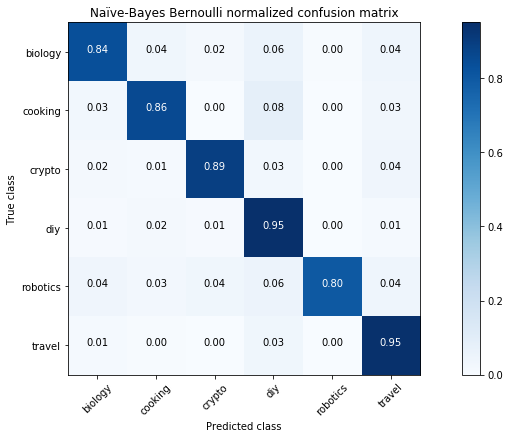

In [19]:
nbb = BernoulliNB()

t0 = time()
nbb.fit(X_train, y_train) 
print('Naïve-Bayes Bernoulli train time: {0:0.3f}s'.format(time()-t0))

t0 = time()
y_pred = nbb.predict(X_valid) 
print('Naïve-Bayes Bernoulli test time: {0:0.3f}s'.format(time()-t0))

cm = confusion_matrix(y_valid, y_pred)                      
print('Accuracy: {0:0.3f}%'.format(100*accuracy_score(y_valid, y_pred)))  
plot_confusion_matrix(cm, l_enc.classes_, title='Naïve-Bayes Bernoulli', normalize=True)

## Random Forest

Random Forest train time: 5.108s
Random Forest test time: 0.142s
Accuracy: 90.339%


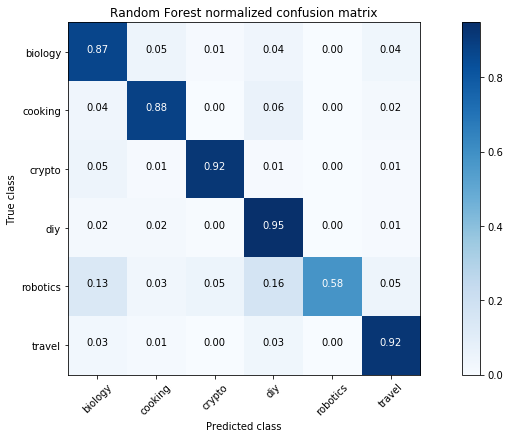

In [20]:
rf = RandomForestClassifier(n_jobs=16)

t0 = time()
rf.fit(X_train, y_train)
print('Random Forest train time: {0:0.3f}s'.format(time()-t0))

t0 = time()
y_pred = rf.predict(X_valid) 
print('Random Forest test time: {0:0.3f}s'.format(time()-t0))
                               
cm = confusion_matrix(y_valid, y_pred)                      
print('Accuracy: {0:0.3f}%'.format(100*accuracy_score(y_valid, y_pred)))  
plot_confusion_matrix(cm, l_enc.classes_, title='Random Forest', normalize=True)

## SVM

SVM train time: 19.049s
SVM test time: 0.064s
Accuracy: 97.431%


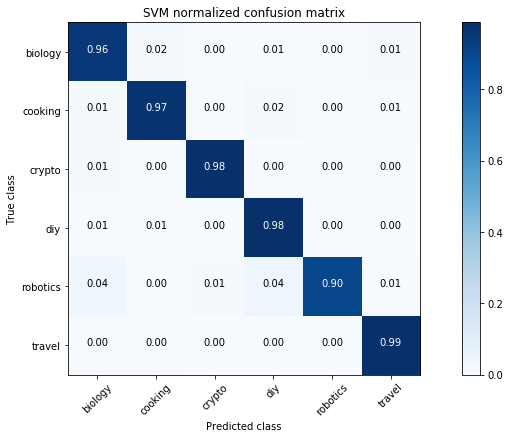

In [21]:
lin_clf = svm.LinearSVC()

t0 = time()
lin_clf.fit(X_train, y_train)
print('SVM train time: {0:0.3f}s'.format(time()-t0))

t0 = time()
y_pred = lin_clf.predict(X_valid)
print('SVM test time: {0:0.3f}s'.format(time()-t0))
                           
cm = confusion_matrix(y_valid, y_pred)                      
print('Accuracy: {0:0.3f}%'.format(100*accuracy_score(y_valid, y_pred)))  
plot_confusion_matrix(cm, l_enc.classes_, title='SVM', normalize=True)

## WiSARD

### OneHot encoding

In [22]:
AddressSize = 5

X_bool_train, y_bool_train = [], []
for example in X_train:
    X_bool_train.append(one_hot(example, min_value=-1.0, max_value=1.0, n=2 ** AddressSize))
y_bool_train = l_enc.inverse_transform(y_train)

X_bool_valid, y_bool_valid = [], []
for example in X_valid:
    X_bool_valid.append(one_hot(example, min_value=-1.0, max_value=1.0, n=2 ** AddressSize))    
y_bool_valid = l_enc.inverse_transform(y_valid)

/home/rafaenune/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/rafaenune/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


### Training & testing...

WiSARD train time: 224.458s
WiSARD test time: 192.695s
Accuracy: 21.799%


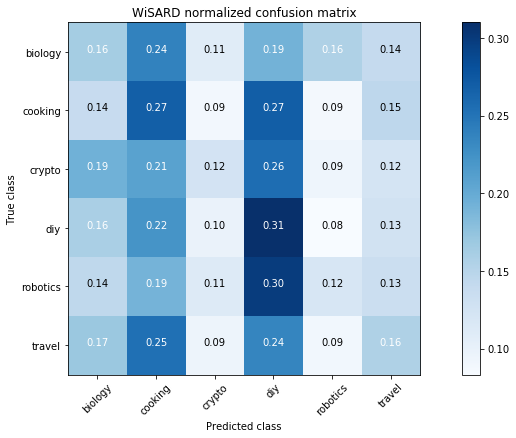

In [23]:
wsd = wp.Wisard(AddressSize, ignoreZero=True, verbose=True)

t0 = time()
wsd.train(X_bool_train, y_bool_train)
print('WiSARD train time: {0:0.3f}s'.format(time()-t0))

t0 = time()
y_pred = wsd.classify(X_bool_valid)
print('WiSARD test time: {0:0.3f}s'.format(time()-t0))

cm = confusion_matrix(l_enc.transform(y_bool_valid), l_enc.transform(y_pred))                      
print('Accuracy: {0:0.3f}%'.format(100*accuracy_score(l_enc.transform(y_bool_valid), l_enc.transform(y_pred))))  
plot_confusion_matrix(cm, l_enc.classes_, title='WiSARD', normalize=True)

## WiSARD with 10% training set

### Resampling

In [24]:
X_train_re, X_valid_re, y_train_re, y_valid_re = train_test_split(X_train, y_train, test_size=0.9, random_state=543)

### OneHot encoding

In [25]:
AddressSize = 5

X_bool_train_re, y_bool_train_re = [], []
for example in X_train_re:
    X_bool_train_re.append(one_hot(example, min_value=-1.0, max_value=1.0, n=2 ** AddressSize))
y_bool_train_re = l_enc.inverse_transform(y_train_re)

/home/rafaenune/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


### Training & testing...

WiSARD with 10% training set train time: 22.932s
WiSARD with 10% training set test time: 187.009s
Accuracy: 25.718%


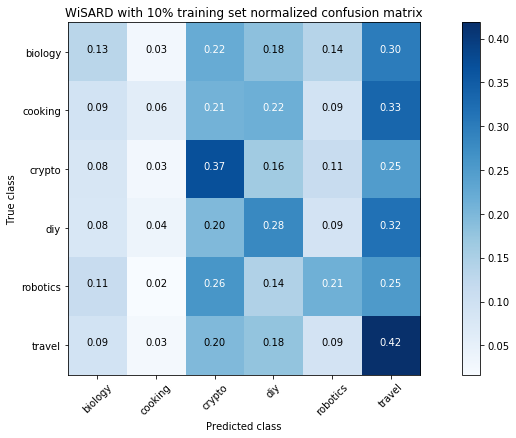

In [26]:
wsd = wp.Wisard(AddressSize, ignoreZero=True, verbose=True)

t0 = time()
wsd.train(X_bool_train_re, y_bool_train_re)
print('WiSARD with 10% training set train time: {0:0.3f}s'.format(time()-t0))

t0 = time()
y_pred = wsd.classify(X_bool_valid)
print('WiSARD with 10% training set test time: {0:0.3f}s'.format(time()-t0))

cm = confusion_matrix(l_enc.transform(y_bool_valid), l_enc.transform(y_pred))                      
print('Accuracy: {0:0.3f}%'.format(100*accuracy_score(l_enc.transform(y_bool_valid), l_enc.transform(y_pred))))  
plot_confusion_matrix(cm, l_enc.classes_, title='WiSARD with 10% training set', normalize=True)